In [ ]:
import pandas as pd
import numpy as np
import math as math
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve


In [ ]:
pf=pd.read_csv('/Users/liyuhan/Desktop/uccba/IS6052 PredictAnalytics/Ireland House Price.csv')
print(pf.head())
print(pf.info())
# 假设 df 是原始的 DataFrame
df = pf.copy()  # 创建一个副本

In [ ]:
print(df.isnull().sum())
df = df.dropna()
cleaned_len = len(df)
print(f"Length after dropping NaN values: {cleaned_len}")     #原13320rows，删除空值后12524rows

In [616]:
unique_value=df['property_scope'].unique()
print('unique values of property_scope are',unique_value) 
unique_availability=df.availability.unique()
print('unique values of availability are',unique_availability)

unique values of property_scope are ['Extended Coverage' 'Land Parcel' 'Constructed Space' 'Usable Interior']
unique values of availability are <DatetimeArray>
['2024-10-17 00:00:00', '2024-01-05 00:00:00', '2024-02-18 00:00:00',
 '2024-12-19 00:00:00', '2024-11-18 00:00:00', '2024-05-18 00:00:00',
 '2024-12-20 00:00:00', '2024-12-21 00:00:00', '2024-09-19 00:00:00',
 '2024-09-20 00:00:00', '2024-03-18 00:00:00', '2024-04-18 00:00:00',
 '2024-08-20 00:00:00', '2024-03-19 00:00:00', '2024-09-17 00:00:00',
 '2024-12-18 00:00:00', '2024-08-17 00:00:00', '2024-04-19 00:00:00',
 '2024-06-18 00:00:00', '2024-12-22 00:00:00', '2024-01-22 00:00:00',
 '2024-08-18 00:00:00', '2024-01-19 00:00:00', '2024-07-17 00:00:00',
 '2024-07-18 00:00:00', '2024-06-21 00:00:00', '2024-05-20 00:00:00',
 '2024-08-19 00:00:00', '2024-09-18 00:00:00', '2024-05-17 00:00:00',
 '2024-06-17 00:00:00', '2024-10-18 00:00:00', '2024-05-21 00:00:00',
 '2024-01-18 00:00:00', '2024-03-20 00:00:00', '2024-12-17 00:00:00',


In [618]:
#将不是日期的删掉，并将该列变为日期类型
counts=df.availability.value_counts()
print(counts)

availability
2024-01-05    9999
2024-12-18     281
2024-05-18     273
2024-04-18     259
2024-08-18     197
              ... 
2024-01-17       1
2024-11-16       1
2024-01-16       1
2024-02-17       1
2024-07-14       1
Name: count, Length: 78, dtype: int64


In [620]:
from datetime import datetime, timedelta
def convert_and_find_earliest(df, column):
    # 月份映射：将英文月份名称转化为数字
    month_mapping = {
        'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
        'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
        'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}
    # 定义一个转换函数来处理每个值
    def convert(value):
        if isinstance(value, str):
            # 处理类似'18-May'格式的日期
            if '-' in value:
                try:
                    # 获取日期和月份
                    day, month_name = value.split('-')
                    # 将月份名称转换为数字
                    month = month_mapping.get(month_name, None)
                    if month:
                        # 构造新的日期字符串，假设年份是2024
                        date_str = f'{day}/{month}/2024'
                        # 转换为datetime对象
                        date = datetime.strptime(date_str, '%d/%m/%Y')
                        return date
                    else:
                        return value  # 如果月份无效，返回原始值
                except ValueError:
                    return value  # 如果转换失败，则返回原始值
            else:
                return value  # 如果格式不匹配，返回原始值
        return value  # 如果值不是字符串，返回原值

    # 应用转换函数，将所有日期字符串转换为datetime对象
    df[column] = df[column].apply(convert)

    # 获取最早日期
    dates = pd.to_datetime(df[column], errors='coerce')  # 转换列中的日期为datetime类型，无法转换的会是NaT
    earliest_date = dates.min()  # 获取最早的日期
    if pd.notna(earliest_date):
        print(f"The earliest date is: {earliest_date.strftime('%d/%m/%Y')}")
    else:
        print("No valid dates found.")

    return df
# 调用函数进行转换并打印最早日期
df = convert_and_find_earliest(df, 'availability')
# 输出转换后的DataFrame
print('***',df['availability'],'***')

replacement_date = datetime(2024, 1, 5)
df['availability'] = df['availability'].replace('Ready To Move', replacement_date)
df['availability'] = df['availability'].replace('Immediate Possession', replacement_date)
# 输出替换后的 DataFrame
print(df['availability'])

The earliest date is: 05/01/2024
*** 0       2024-10-17
1       2024-01-05
2       2024-01-05
3       2024-01-05
4       2024-01-05
           ...    
13314   2024-01-05
13315   2024-01-05
13317   2024-01-05
13318   2024-06-18
13319   2024-01-05
Name: availability, Length: 12524, dtype: datetime64[ns] ***
0       2024-10-17
1       2024-01-05
2       2024-01-05
3       2024-01-05
4       2024-01-05
           ...    
13314   2024-01-05
13315   2024-01-05
13317   2024-01-05
13318   2024-06-18
13319   2024-01-05
Name: availability, Length: 12524, dtype: datetime64[ns]


In [622]:
#locational列：分类变量，先检查唯一值
unique_location=df.location.unique()
print('unique_locations:',unique_location)

unique_locations: ['Fingal' 'South Dublin' 'Dun Laoghaire' 'DCC' 'Other']


In [624]:
#size列的处理：更改列名为number of bedrooms，转换数据类型，检查唯一值，仅保留数字
df.rename(columns={'size':'number of bedrooms'},inplace=True) #更改size列的名称
df['number of bedrooms'] = df['number of bedrooms'].astype(str)
df['number of bedrooms']=df['number of bedrooms'].str.replace(r'\D+','',regex=True)  #混合字符串，选择仅保留其中的数字
print(df['number of bedrooms'].head())  #检查
print(df['number of bedrooms'].isnull().sum())
df = df.dropna(subset=['number of bedrooms'])
  #将该列object转换为int类型

df = df[df['number of bedrooms'] != '']
# Step 5: 检查是否有缺失值
print(df['number of bedrooms'].isnull().sum())  # 应该输出0

df['number of bedrooms']=df['number of bedrooms'].astype(int) 
print(df.dtypes)  #检查

0    2
1    4
2    3
3    3
4    2
Name: number of bedrooms, dtype: object
0
0
ID                                 int64
property_scope                    object
availability              datetime64[ns]
location                          object
number of bedrooms                 int64
total_sqft                        object
bath                             float64
balcony                          float64
buy_state                         object
BER                               object
renovation_needed                 object
price(€/sqtf)                    float64
property_scope_encoded             int64
location_encoded                   int64
buy_state_encoded                  int64
BER_encoded                        int64
dtype: object


In [626]:
#total_sqft列的处理:将范围替换为范围的平均值，需要将整列object转换为int，怎么做？❌
df['total_sqft'] = df['total_sqft'].astype(str)
mask = df['total_sqft'].str.contains('-', na=False)
# 处理范围的值
def calculate_average(value):
    # 将范围值拆分为上下限
    lower, upper = map(int, value.split('-'))
    return (lower + upper) / 2
# 对筛选的行进行替换
df.loc[mask, 'total_sqft'] = df.loc[mask, 'total_sqft'].apply(calculate_average)
# 将列转换为浮点型或整型
df['total_sqft'] = df['total_sqft'].astype(float)
# 输出结果
print(df['total_sqft'])

0        1056.0
1        2600.0
2        1440.0
3        1521.0
4        1200.0
          ...  
13314    1715.0
13315    3453.0
13317    1141.0
13318    4689.0
13319     550.0
Name: total_sqft, Length: 12524, dtype: float64


In [628]:
print(df.bath.isnull().sum())
df['bath']=df['bath'].astype(int)
print('///',df['bath'].dtype,'///')

0
/// int64 ///


In [630]:
df['balcony']=df['balcony'].astype(int)
print(df['balcony'].dtype)

int64


In [7]:
unique_value=df['buying or not buying'].unique()
print('unique values of buying or not buying are',unique_value) 
df.rename(columns={'buying or not buying':'buy_state'},inplace=True)
print(df.head())

NameError: name 'df' is not defined

In [640]:
unique_BER=df.BER.unique()
print(unique_BER)

['A' 'D' 'G' 'F' 'B' 'C' 'E']


In [642]:
df.rename(columns={'Renovation needed':'renovation_needed'},inplace=True)
unique_renovation_needed=df.renovation_needed.unique()
print(unique_renovation_needed)
print(df['renovation_needed'].value_counts())
df['renovation_needed']=df['renovation_needed'].astype(object)

['No' 'Yes' 'Maybe']
renovation_needed
Yes      7062
Maybe    3695
No       1767
Name: count, dtype: int64


In [644]:
df.rename(columns={'price-per-sqft-$': 'price(€/sqtf)'}, inplace=True)
print(df.columns)

# 确保该列为数值类型，然后进行格式化
df['price(€/sqtf)'] = pd.to_numeric(df['price(€/sqtf)'], errors='coerce')  # 确保转换为数值，错误值将为 NaN

# 格式化为字符串（保留两位小数）
df['price(€/sqtf)'] = df['price(€/sqtf)'].apply(lambda x: '{:.2f}'.format(x) if pd.notnull(x) else x)

# 打印格式化后的数据
print(df['price(€/sqtf)'].head())
df['price(€/sqtf)']=df['price(€/sqtf)'].astype(float)
print(df['price(€/sqtf)'].head())

Index(['ID', 'property_scope', 'availability', 'location',
       'number of bedrooms', 'total_sqft', 'bath', 'balcony', 'buy_state',
       'BER', 'renovation_needed', 'price(€/sqtf)', 'property_scope_encoded',
       'location_encoded', 'buy_state_encoded', 'BER_encoded'],
      dtype='object')
0    419.93
1    523.85
2    488.68
3    708.91
4    482.38
Name: price(€/sqtf), dtype: object
0    419.93
1    523.85
2    488.68
3    708.91
4    482.38
Name: price(€/sqtf), dtype: float64


In [646]:
#检查
print(df.info()) #检查

<class 'pandas.core.frame.DataFrame'>
Index: 12524 entries, 0 to 13319
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      12524 non-null  int64         
 1   property_scope          12524 non-null  object        
 2   availability            12524 non-null  datetime64[ns]
 3   location                12524 non-null  object        
 4   number of bedrooms      12524 non-null  int64         
 5   total_sqft              12524 non-null  float64       
 6   bath                    12524 non-null  int64         
 7   balcony                 12524 non-null  int64         
 8   buy_state               12524 non-null  object        
 9   BER                     12524 non-null  object        
 10  renovation_needed       12524 non-null  object        
 11  price(€/sqtf)           12524 non-null  float64       
 12  property_scope_encoded  12524 non-null  int64      

In [648]:
# 1. 选择数值列
numeric_df = df.select_dtypes(include=[np.number])

# 2. 计算每列的 Z-score
z_scores = numeric_df.apply(zscore)

# 3. 设置阈值，通常超过 3 或小于 -3 被视为异常值
threshold = 3

# 4. 找到异常值（Z-score 大于阈值的值）
outliers = (z_scores.abs() > threshold)

# 5. 计算并显示每列异常值的数量
for column in numeric_df.columns:
    outlier_count = outliers[column].sum()  # 计算每列异常值的数量
    print(f"Column '{column}' has {outlier_count} outliers.")

Column 'ID' has 0 outliers.
Column 'number of bedrooms' has 196 outliers.
Column 'total_sqft' has 98 outliers.
Column 'bath' has 161 outliers.
Column 'balcony' has 0 outliers.
Column 'price(€/sqtf)' has 5 outliers.
Column 'property_scope_encoded' has 76 outliers.
Column 'location_encoded' has 0 outliers.
Column 'buy_state_encoded' has 0 outliers.
Column 'BER_encoded' has 0 outliers.


In [650]:
outlier_rows = outliers.any(axis=1)  # 如果任意一列有异常值，则该行就是异常值行

# 6. 删除含有异常值的行
df_cleaned = df[~outlier_rows]  # 保留不含异常值的行

# 7. 打印删除后的行数
print(f"Original number of rows: {len(df)}")
print(f"Number of rows after removing outliers: {len(df_cleaned)}")

Original number of rows: 12524
Number of rows after removing outliers: 12139


In [668]:
# 使用 One-Hot Encoding 对 feature1 列进行编码 ----01编码并不适合

# 初始化 LabelEncoder
label_encoder = LabelEncoder()

# 对 'scope' 列进行编码
df['property_scope_encoded'] = label_encoder.fit_transform(df['property_scope'])
df['location_encoded'] = label_encoder.fit_transform(df['location'])
df['buy_state_encoded'] = label_encoder.fit_transform(df['buy_state'])
df['BER_encoded'] = label_encoder.fit_transform(df['BER'])
df['renovation_needed_encoded'] = label_encoder.fit_transform(df['renovation_needed'])
# 打印编码后的 DataFrame
print("\nDataFrame after Label Encoding:")
print(df)
#,'location','buy_state','BER','renovation_needed'])


DataFrame after Label Encoding:
          ID     property_scope availability       location  \
0          0  Extended Coverage   2024-10-17         Fingal   
1          1        Land Parcel   2024-01-05   South Dublin   
2          2  Constructed Space   2024-01-05  Dun Laoghaire   
3          3  Extended Coverage   2024-01-05   South Dublin   
4          4  Extended Coverage   2024-01-05            DCC   
...      ...                ...          ...            ...   
13314  13314  Extended Coverage   2024-01-05         Fingal   
13315  13315  Constructed Space   2024-01-05  Dun Laoghaire   
13317  13317  Constructed Space   2024-01-05         Fingal   
13318  13318  Extended Coverage   2024-06-18   South Dublin   
13319  13319  Extended Coverage   2024-01-05         Fingal   

       number of bedrooms  total_sqft  bath  balcony buy_state BER  \
0                       2      1056.0     2        1        No   A   
1                       4      2600.0     5        3        No   D   


ID                                    int64
property_scope                       object
availability                 datetime64[ns]
location                             object
number of bedrooms                    int64
total_sqft                          float64
bath                                  int64
balcony                               int64
buy_state                            object
BER                                  object
renovation_needed                    object
price(€/sqtf)                       float64
property_scope_encoded                int64
location_encoded                      int64
buy_state_encoded                     int64
BER_encoded                           int64
renovation_needed_encoded             int64
dtype: object
Index(['location', 'renovation_needed', 'BER', 'buy_state', 'property_scope',
       'number of bedrooms', 'total_sqft', 'bath', 'balcony', 'price(€/sqtf)'],
      dtype='object')
       location  renovation_needed  BER  buy_state  proper

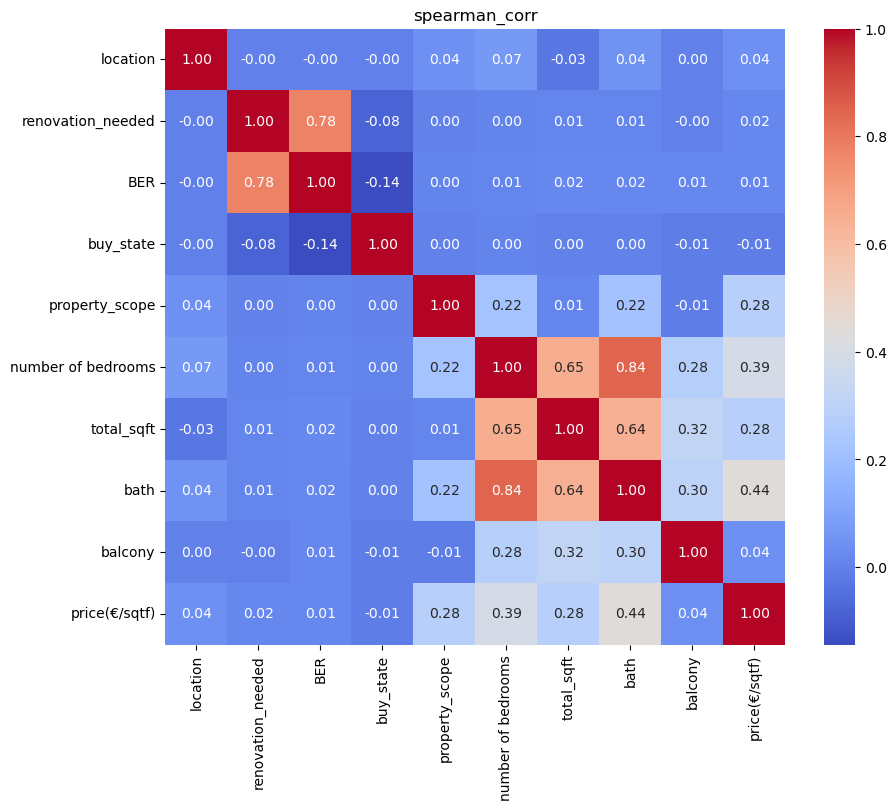

In [678]:
print(df.dtypes)
encoded_df = df[['location_encoded', 'renovation_needed_encoded','BER_encoded','buy_state_encoded','property_scope_encoded','number of bedrooms',  'total_sqft',  'bath', 'balcony','price(€/sqtf)']]
# 用 str.replace() 删除列名中的 'encoded'
encoded_df.columns = encoded_df.columns.str.replace('_encoded', '', regex=False)
# 打印修改后的列名
print(encoded_df.columns)

# 打印新的 DataFrame
print(encoded_df)

#以上相关性矩阵数值太小，说明属于非线性关系，则选择计算spearman cor
spearman_corr = encoded_df.corr(method='spearman')
print(spearman_corr)
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("spearman_corr")
plt.show() #通过hotmap可以直观地看出三个目标变量之间没有多重共线性，所以不用过多考虑。

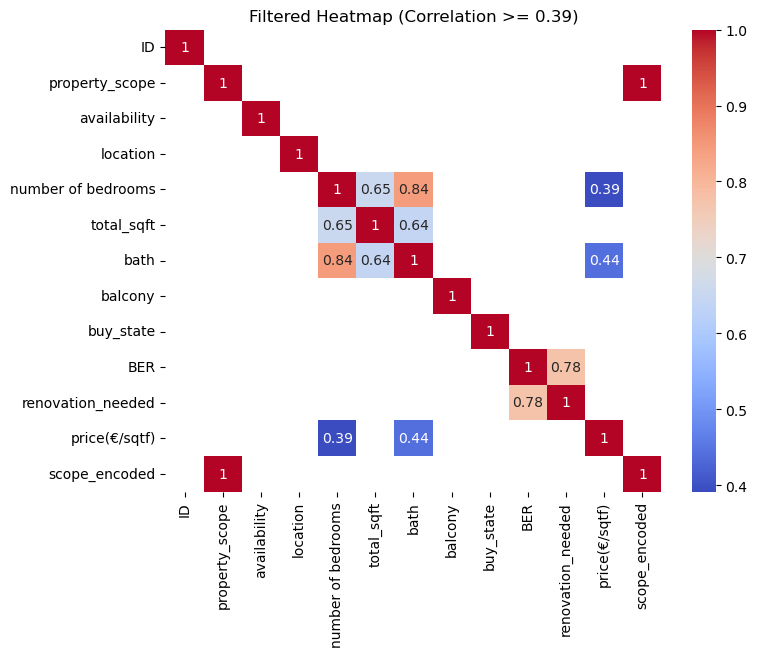

In [680]:
target_variables = ['renovation_needed', 'buy_state', 'price(€/sqtf)']

# 遍历每个目标变量，打印与其相关性大于等于0.39的特征
for target in target_variables:
    print(f"Features with correlation >= 0.39 with {target}:")
    
 # 筛选与目标变量相关性大于等于 0.39 的特征
relevant_features_price = spearman_corr['price(€/sqtf)'][spearman_corr['price(€/sqtf)'].abs() >= 0.39].index.tolist()
# 对 'renovation needed' 和 'buy_state' 进行相同的操作
relevant_features_renovation_needed = spearman_corr['renovation_needed'][spearman_corr['renovation_needed'].abs() >= 0.39].index.tolist()
relevant_features_buy_state = spearman_corr['buy_state'][spearman_corr['buy_state'].abs() >= 0.39].index.tolist()

# 打印出相关性大于等于 0.39 的特征
print(f"Features with correlation >= 0.39 with 'price(€/sqtf)': {relevant_features_price}")
print(f"Features with correlation >= 0.39 with 'renovation needed': {relevant_features_renovation_needed}")
print(f"Features with correlation >= 0.39 with 'buy_state': {relevant_features_buy_state}")


Features with correlation >= 0.39 with renovation_needed:
Features with correlation >= 0.39 with buy_state:
Features with correlation >= 0.39 with price(€/sqtf):
Features with correlation >= 0.39 with 'price(€/sqtf)': ['number of bedrooms', 'bath', 'price(€/sqtf)']
Features with correlation >= 0.39 with 'renovation needed': ['renovation_needed', 'BER']
Features with correlation >= 0.39 with 'buy_state': ['buy_state']


In [686]:
#再用随机森林再次检验一下各项特征的重要性。 （因为availability相关性很小，所以在这里直接舍掉了，要不然datetime类型没办法做随机森林重要性计算）
# 定义特征和目标变量
X = encoded_df[['property_scope', 'location', 'number of bedrooms', 
        'total_sqft', 'bath', 'balcony']]  # 特征列
y = encoded_df[['renovation_needed', 'buy_state', 'price(€/sqtf)']]  # 目标变量列


# 定义随机森林模型并包装为多目标回归器
base_model = RandomForestRegressor(random_state=42)
model = MultiOutputRegressor(base_model)

# 拟合模型
model.fit(X, y)

# 打印特征重要性
print("Feature Importances for Each Target:")
for i, target in enumerate(y.columns):
    feature_importances = model.estimators_[i].feature_importances_  # 获取第 i 个目标的特征重要性
    print(f"Target: {target}")
    for col, importance in zip(X.columns, feature_importances):
        print(f"Feature: {col}, Importance: {importance}")
    print("-" * 50)
    #重要性>0.1 算重要

Feature Importances for Each Target:
Target: renovation_needed
Feature: property_scope, Importance: 0.06640738780508897
Feature: location, Importance: 0.1377713932995353
Feature: number of bedrooms, Importance: 0.07157405425870192
Feature: total_sqft, Importance: 0.529151177761732
Feature: bath, Importance: 0.07424410312672662
Feature: balcony, Importance: 0.12085188374821507
--------------------------------------------------
Target: buy_state
Feature: property_scope, Importance: 0.07883539648301573
Feature: location, Importance: 0.049170350326027526
Feature: number of bedrooms, Importance: 0.07607859882341783
Feature: total_sqft, Importance: 0.5993181623009773
Feature: bath, Importance: 0.07469750244354213
Feature: balcony, Importance: 0.12189998962301946
--------------------------------------------------
Target: price(€/sqtf)
Feature: property_scope, Importance: 0.09797411793708073
Feature: location, Importance: 0.30705139884023036
Feature: number of bedrooms, Importance: 0.054480700

In [370]:
# 假设 df 是包含数据的 DataFrame
X = df[['property_scope', 'location', 'number of bedrooms', 
        'total_sqft', 'bath', 'scope_encoded', 'balcony']]  # 特征列
y = df[['renovation_needed', 'buy_state', 'price(€/sqtf)']]  # 目标变量列

# 定义随机森林模型并包装为多目标回归器
base_model = RandomForestRegressor(random_state=42)
model = MultiOutputRegressor(base_model)

# 拟合模型
model.fit(X, y)

# 设置特征选择阈值，选择重要性大于阈值的特征
importance_threshold = 0.1  # 可以调整此阈值来选择合适的特征

# 创建一个字典来保存每个目标变量的重要特征
important_features_per_target = {}

# 打印每个目标变量的特征重要性，并挑选出重要的特征
for i, target in enumerate(y.columns):
    feature_importances = model.estimators_[i].feature_importances_  # 获取第 i 个目标的特征重要性
    feature_importances_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    })
    
    # 按照重要性排序，选择大于阈值的特征
    important_features = feature_importances_df[feature_importances_df['Importance'] > importance_threshold]
    
    # 将结果保存到字典中
    important_features_per_target[target] = important_features['Feature'].tolist()

    print(f"Important Features for {target}:")
    print(important_features[['Feature', 'Importance']])
    print("-" * 50)

# 打印每个目标变量选择的重要特征
print("\nSelected Important Features for Each Target:")
for target, features in important_features_per_target.items():
    print(f"{target}: {features}")


Important Features for renovation_needed:
      Feature  Importance
1    location    0.137298
3  total_sqft    0.528640
6     balcony    0.120371
--------------------------------------------------
Important Features for buy_state:
      Feature  Importance
3  total_sqft    0.598739
6     balcony    0.120827
--------------------------------------------------
Important Features for price(€/sqtf):
      Feature  Importance
1    location    0.307189
3  total_sqft    0.290893
6     balcony    0.180147
--------------------------------------------------

Selected Important Features for Each Target:
renovation_needed: ['location', 'total_sqft', 'balcony']
buy_state: ['total_sqft', 'balcony']
price(€/sqtf): ['location', 'total_sqft', 'balcony']


AUC-ROC for each class:
Class Maybe: 0.4959
Class No: 0.5071
Class Yes: 0.4895


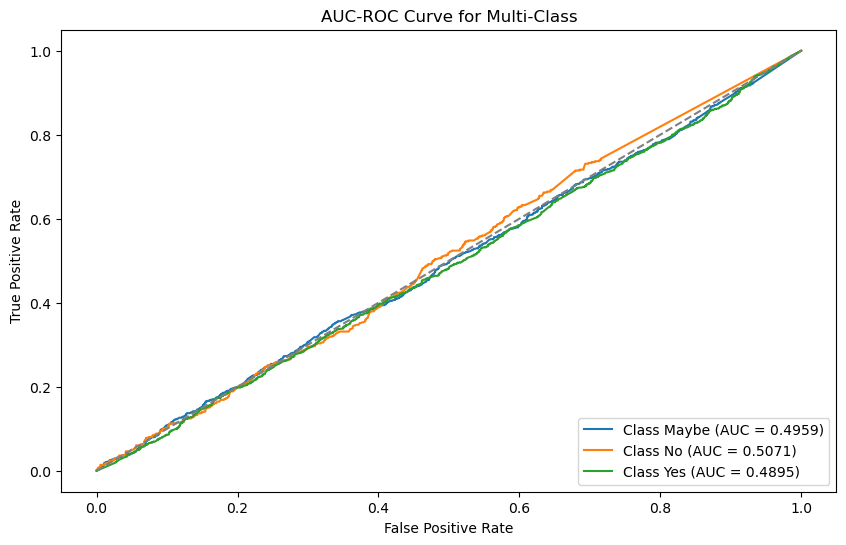

In [729]:
'''# 假设 df 是你的数据框，'location', 'total_sqft', 'balcony' 是特征列，'renovation_needed' 是目标变量

# 特征和目标变量
X = encoded_df[['location', 'total_sqft', 'balcony']]
y = encoded_df['renovation_needed']


# 数据划分：训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 训练随机森林模型，使用 class_weight='balanced' 来处理类别不平衡
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# 拟合模型
model.fit(X_train, y_train)

# 预测概率值
y_probs = model.predict_proba(X_test)

# AUC-ROC计算：需要计算每个类别的 AUC
auc_scores = {}
for i in range(y.nunique()):
    auc_scores[label_encoder.inverse_transform([i])[0]] = roc_auc_score(y_test == i, y_probs[:, i])

# 打印每个类别的 AUC
print("AUC-ROC for each class:")
for target, score in auc_scores.items():
    print(f"Class {target}: {score:.4f}")

# 绘制 AUC-ROC 曲线
plt.figure(figsize=(10, 6))
for i in range(y.nunique()):
    fpr, tpr, _ = roc_curve(y_test == i, y_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {label_encoder.inverse_transform([i])[0]} (AUC = {auc_scores[label_encoder.inverse_transform([i])[0]]:.4f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('AUC-ROC Curve for Multi-Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


#AUC值的范围是 [0, 1]，越接近1表示模型越好。
#AUC=0.5 表示模型表现不佳，几乎和随机猜测一样。
#AUC=1 表示模型完美预测，所有正例和负例都能完美分开。
'''



F1-Score: 0.4466
Confusion Matrix:
[[ 115   18  968]
 [  51   14  433]
 [ 250   39 1870]]


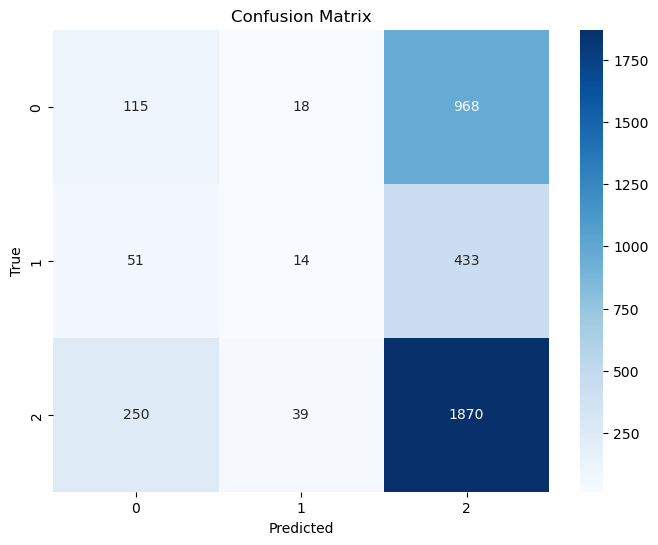


Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.10      0.15      1101
           1       0.20      0.03      0.05       498
           2       0.57      0.87      0.69      2159

    accuracy                           0.53      3758
   macro avg       0.35      0.33      0.30      3758
weighted avg       0.44      0.53      0.45      3758



In [731]:
'''# 计算F1-score
f1 = f1_score(y_test, y_pred, average='weighted')  # 使用加权平均
print(f"F1-Score: {f1:.4f}")
# 打印混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 打印分类报告，包括精度、召回率、F1-score等
print("\nClassification Report:")
print(classification_report(y_test, y_pred))'''

In [5]:
#通过上述随机森林模型的评估，其实发现最大的问题还是分类不平衡，考虑使用支持向量机（SVM）# 导入必要的库
X = encoded_df[['location', 'total_sqft', 'balcony']]  # 特征
y = encoded_df['renovation_needed']  # 目标变量（类别）

# 数据划分：训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 初始化SVM模型，并且使用'ovo'（一对一）策略
model = SVC(kernel='linear', decision_function_shape='ovo', class_weight='balanced', random_state=42)

# 拟合模型
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估模型
# 计算F1-score
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' 平均会考虑类的不平衡
print(f'F1-Score: {f1:.4f}')

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 分类报告
print("Classification Report:")
print(classification_report(y_test, y_pred))

# AUC-ROC计算：需要计算每个类别的 AUC
# SVM的predict_proba方法返回每个类别的概率分布
y_probs = model.predict_proba(X_test)

# 计算每个类别的AUC
auc_scores = {}
for i in range(y.nunique()):
    auc_scores[i] = roc_auc_score(y_test == i, y_probs[:, i])

print("AUC-ROC for each class:")
for target, score in auc_scores.items():
    print(f"Class {target}: {score:.4f}")

# 绘制 AUC-ROC 曲线
plt.figure(figsize=(10, 6))
for i in range(y.nunique()):
    fpr, tpr, _ = roc_curve(y_test == i, y_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_scores[i]:.4f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('AUC-ROC Curve for Multi-Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


NameError: name 'encoded_df' is not defined